In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "drive/My Drive/Ktrain.zip"
!unzip "drive/My Drive/Kval.zip"

In [11]:
import keras,os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np

# base_dir = '/root/Project'

# train_dir = os.path.join(base_dir, 'Ktrain')
# validation_dir = os.path.join(base_dir, 'Kval')
# test_dir = os.path.join(base_dir, 'Ktest')

train_dir = 'Ktrain'
validation_dir = 'Kval'
test_dir = 'Ktest'

# Directory with our training ad pictures
train_ads_dir = os.path.join(train_dir, 'pos')

# Directory with our training dog pictures
train_noads_dir = os.path.join(train_dir, 'neg')

# Directory with our validation ad pictures
validation_ads_dir = os.path.join(validation_dir, 'pos')

# Directory with our validation dog pictures
validation_noads_dir = os.path.join(validation_dir, 'neg')


In [12]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [13]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (300, 300))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (300, 300))

Found 359 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [14]:
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten , Dropout
from keras.applications.vgg16 import VGG16
from keras.metrics import TruePositives, TrueNegatives, FalseNegatives, FalsePositives,Recall , Precision, BinaryAccuracy

base_model = VGG16(input_shape = (300, 300, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
# Flatten the output layer to 1 dimension
x = Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = Dense(1, activation='sigmoid')(x)

model = keras.models.Model(base_model.input, x)

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = [BinaryAccuracy(),
        TruePositives(),
        TrueNegatives(),
        FalsePositives(),
        FalseNegatives(),
        Precision(),
        Recall()])

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
 18/100 [====>.........................] - ETA: 25:10 - loss: 0.3119 - binary_accuracy: 0.8524 - true_positives: 151.0000 - true_negatives: 155.0000 - false_positives: 24.0000 - false_negatives: 29.0000 - precision: 0.8629 - recall: 0.8389

100/100 [==============================] - 478s 5s/step - loss: 0.3119 - binary_accuracy: 0.8524 - true_positives: 151.0000 - true_negatives: 155.0000 - false_positives: 24.0000 - false_negatives: 29.0000 - precision: 0.8629 - recall: 0.8389 - val_loss: 0.1216 - val_binary_accuracy: 0.9500 - val_true_positives: 54.0000 - val_true_negatives: 60.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 6.0000 - val_precision: 1.0000 - val_recall: 0.9000


In [16]:
from keras.models import load_model

# Save model
model.save("Trend_Ad_NoAd_VGG.h5")

In [ ]:
!unzip "drive/My Drive/Ktest.zip"

In [18]:
from keras.models import load_model
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

# Flow test images in batches of 20 using test_datagen generator
test_gen = ImageDataGenerator( rescale = 1.0/255. )
test_generator = test_gen.flow_from_directory( test_dir,  batch_size = 20, class_mode = 'binary', target_size = (300, 300))
saved_model = load_model("Trend_Ad_NoAd_VGG.h5")

# Evaluate on test data
scores = saved_model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("evaluate ",saved_model.metrics_names[1], scores[1]*100))

Found 120 images belonging to 2 classes.
6/6 [==============================] - 112s 18s/step - loss: 0.1906 - binary_accuracy: 0.9583 - true_positives: 56.0000 - true_negatives: 59.0000 - false_positives: 1.0000 - false_negatives: 4.0000 - precision: 0.9825 - recall: 0.9333
evaluate binary_accuracy: 95.83%


        Metric              Value
0       0.19059711694717407 loss
1       0.9583333134651184  binary_accuracy
2       56.0                true_positives
3       59.0                true_negatives
4       1.0                 false_positives
5       4.0                 false_negatives
6       0.9824561476707458  precision
7       0.9333333373069763  recall


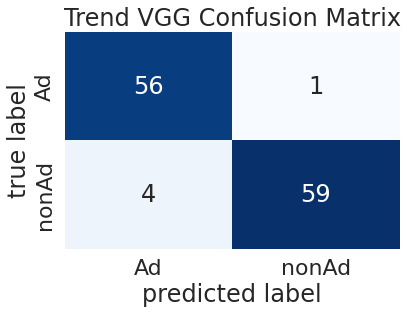

In [19]:
import numpy as np
import seaborn as sns; sns.set_theme()

fmt = '{:<8}{:<20}{}'

print(fmt.format('', 'Metric', 'Value'))
for i, (a, b) in enumerate(zip(scores, model.metrics_names)):
    print(fmt.format(i, a, b))

sns.set(font_scale=2)

def plot_matrix(cm, classes, title):
  ax = sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes, cbar=False, fmt='g')
  ax.set(title=title, xlabel="predicted label", ylabel="true label")
    
cm = np.array([[scores[2],scores[4]],[scores[5],scores[3]]])
classes = ['Ad', 'nonAd']
title = "Trend VGG Confusion Matrix"

plot_matrix(cm, classes, title)